# Image coloring using Generative Adversarial Networks

Authors:
- Daniel García Algora
- David García Guillén
- Carlos Hernández López
- Álvaro Tena Tamayo

---

In [220]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from time import time
from skimage.color import rgb2lab, lab2rgb
from keras.datasets import cifar10
import cv2
from joblib import Parallel, delayed

import tensorflow as tf

from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU, UpSampling2D)



from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model

### Image preprocessing

For the time being, we will be using the CIFAR-10 dataset (32x32)

In [221]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


In [222]:
def rgb_to_grayscale(images):
    """
    Converts RGB image list to convert to grayscale.

    Args:
    images (list of numpy arrays): RGB image list.

    Returns:
    list of numpy arrays: grayscale image list.
    """
    grayscale_images = []
    for img in images:
        grayscale_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        grayscale_images.append(grayscale_img)
    return grayscale_images

In [223]:
x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

In [224]:
import numpy as np
import matplotlib.pyplot as plt

def show_random_image(x_data_gray, x_data_color, dataset_name, title=None, cmap=None):
    """
    Muestra una imagen aleatoria de un conjunto de datos.

    Args:
    x_data (numpy array): Dataset containing images.
    dataset_name (str): Dataset's name.
    title (str, opcional): Image title.
    cmap (str, opcional): Colour map.

    Returns:
    None
    """
    # select random image
    random_index = np.random.randint(0, len(x_data_gray))
    random_image_gray = x_data_gray[random_index]
    random_image_color = x_data_color[random_index]

    # plot gray image
    plt.imshow(random_image_gray, cmap=cmap)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.suptitle(f'Random {dataset_name} image')
    plt.show()

     # plot colored image
    plt.imshow(random_image_color, cmap=cmap)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.suptitle(f'Random {dataset_name} image')
    plt.show()

In [225]:
class Dataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __iter__(self):
      return iter(zip(self.x, self.y))

In [226]:
train_dataset = Dataset(x_train_gray, x_train)
test_dataset = Dataset(x_test_gray, x_test)

training_data = train_dataset.x

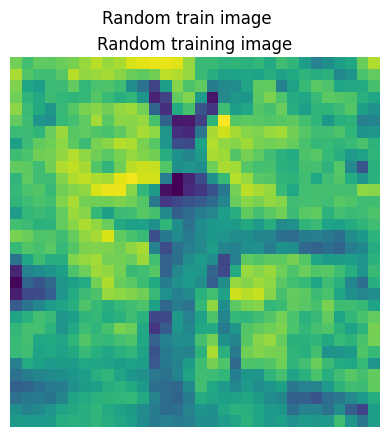

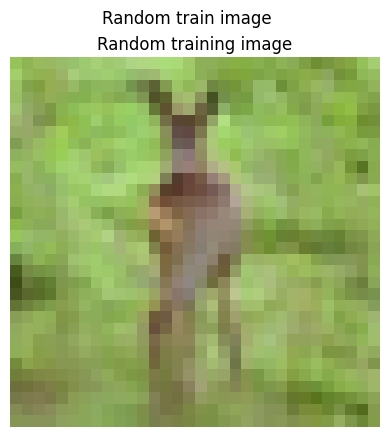

In [227]:
show_random_image(train_dataset.x, train_dataset.y, 'train', title="Random training image")

## Model definition (convolutional)

In [228]:
from keras.layers import Reshape

def make_generator_model():
    model = Sequential()
    # Agrega una capa de redimensión para convertir las entradas de (32, 32) a (32, 32, 1)
    model.add(Reshape((32, 32, 1), input_shape=(32, 32, 1)))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', strides=2, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', strides=2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(UpSampling2D(size=(2,2)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(2, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))

    return model


In [229]:
def make_discriminator_model():
    model = Sequential()

    model.add(Reshape((32, 32, 1), input_shape=(32, 32, 1)))

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [230]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [231]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [232]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [233]:
"""
# worth considering

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss
"""

'\n# worth considering \n\ndef discriminator_loss(disc_real_output, disc_generated_output):\n    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)\n    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)\n    total_disc_loss = real_loss + generated_loss\n    return total_disc_loss\n\n\ndef generator_loss(disc_generated_output, gen_output, target):\n    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)\n    # mean absolute error\n    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))\n    total_gen_loss = gan_loss + (LAMBDA * l1_loss)\n    return total_gen_loss, gan_loss, l1_loss\n'

## Training

In [234]:
WORKDIR = "/content/checkpoints"
IMAGE_SIZE = 32

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)


In [235]:
summary_log_file = os.path.join(
    WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        generator.summary()
        discriminator.summary()

        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator(tf.keras.layers.concatenate([input_image, target]), training=True)
        disc_generated_output = discriminator(tf.keras.layers.concatenate([input_image, gen_output]), training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_total_loss, disc_loss



In [236]:
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print('[+] Restored from {}'.format(manager.latest_checkpoint))
else:
    print('[+] Initializing from scratch')

[+] Initializing from scratch


Some constants are needed for the training to take place:

In [238]:
IMAGE_SIZE = 32
EPOCHS = 150
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

In [239]:
for e in range(EPOCHS):
    start_time = time()
    gen_loss_total = disc_loss_total = 0


    for input_image, target in train_dataset:
        gen_loss, disc_loss = train_step(input_image, target, e)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    time_taken = time() - start_time

    if (e + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('[+] Epoch {}: gen loss: {}, disc loss: {}, time: {:.2f}s'.format(
         e + 1, gen_loss_total / BATCH_SIZE, disc_loss_total / BATCH_SIZE, time_taken))


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 32, 32, 1)         0         
                                                                 
 conv2d_78 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 conv2d_79 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_42 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_80 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_81 (Conv2D)          (None, 8, 8, 128)         147584    
                                                     

ValueError: in user code:

    File "<ipython-input-235-af2219b05a07>", line 12, in train_step  *
        gen_output = generator(input_image, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'reshape_1' (type Reshape).
    
    Cannot reshape a tensor with 1024 elements to shape [32,32,32,1] (32768 elements) for '{{node sequential_17/reshape_1/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](sequential_17/Cast, sequential_17/reshape_1/Reshape/shape)' with input shapes: [32,32], [4] and with input tensors computed as partial shapes: input[1] = [32,32,32,1].
    
    Call arguments received by layer 'reshape_1' (type Reshape):
      • inputs=tf.Tensor(shape=(32, 32), dtype=float32)
